# Algoritmo Viterbi
### Hafid Oxte
### Fernando Perez

Dada una secuencia de símbolo visible V^(T) y el modelo ( θ → { A , B }) encuentra la secuencia más probable de estados ocultos S^(T).

En general, podríamos intentar encontrar todos los diferentes escenarios de estados ocultos para la secuencia dada de símbolos visibles y luego identificar el más probable. Sin embargo, tal como hemos visto anteriormente, será un problema O exponencialmente complejo O(N^(T) . T) resolver.

El problema de decodificación es similar al Forward Algorithm. En el algoritmo de avance, calculamos la probabilidad de la secuencia de observación, dadas las secuencias ocultas mediante la suma de todas las probabilidades, sin embargo, en el problema de descodificación debemos encontrar el most probableestado oculto en cada iteración de t.

La siguiente ecuación representa la probabilidad más alta a lo largo de una ruta única para las primeras tobservaciones que termina en el estado i.
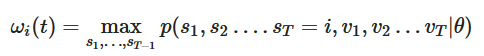

Podemos utilizar el mismo enfoque que el delantero algoritmo para calcular ωi(+1)
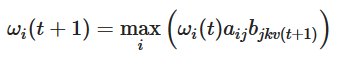

Ahora para encontrar la secuencia de estados ocultos necesitamos identificar el estado que maximiza ωi(t) en cada paso del tiempo t.
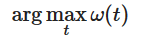

Una vez que complete los pasos anteriores para todas las observaciones, primero encontrar la última oculta estado de máxima verosimilitud, a continuación, utilizando backpointerpara backtrackel camino más probable oculta .

### Ejemplo:

Nuestro ejemplo será el mismo que se usó durante la programación, donde tenemos dos estados ocultos A,By tres símbolos visibles 1,2,3. Asumamos que tenemos una secuencia de 6símbolos visibles y el modelo θ. Necesitamos predecir la secuencia de los estados ocultos para los símbolos visibles.

Si dibujamos el diagrama de enrejado, S1=A y S2=B.

Como se indicó anteriormente, debemos averiguar, para cada paso de tiempo ty cada estado oculto, cuál será el siguiente estado oculto más probable.

Supongamos cuando t = 2, la probabilidad de transición a S2( 2 )de S1( 1 )es más alto que la transición a S1( 2 ), así que seguimos esto. Esto se resalta con la flecha roja de S1( 1 )a S2( 2 )En el siguiente diagrama. La otra ruta está en una línea discontinua gris , que no es necesaria ahora.

Como sabio, repetimos lo mismo para cada estado oculto. En otras palabras, asumiendo que t=1si S2( 1 )era el estado oculto y t=2 la probabilidad de transición a S1( 2 )de S2( 1 ) Es más alto, de ahí que se destaque en rojo.
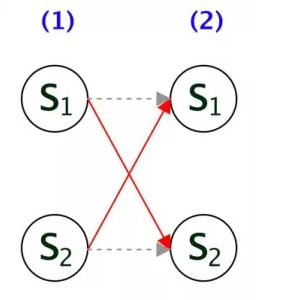

Podemos repetir el mismo proceso para todas las observaciones restantes. El diagrama enrejado se verá como el siguiente.
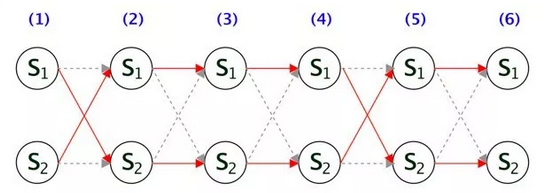

La salida del proceso anterior es tener las secuencias de los estados más probables (1) [diagrama de abajo] y las probabilidades correspondientes (2). Así que a medida que buscamos el estado más probable (1) para cada paso de tiempo, tendremos una 2x5matriz (en general M x (T-1)) como la siguiente:
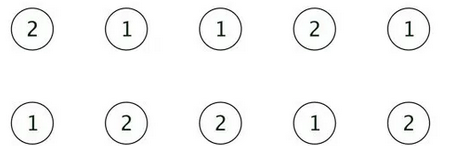

El primer número 2en el diagrama anterior indica que el paso oculto actual 1(ya que está en la primera fila ) hizo la transición desde el paso oculto anterior 2.

Tomemos un ejemplo más, el 2de la segunda fila de la segunda columna indica que el paso actual 2(ya que está en la segunda fila ) hizo la transición desde el paso anterior oculto 2. Si hace referencia fig 1, puede ver que es cierto, ya que en un momento dado 3, el estado oculto S2transisitoned de S2 [según la línea de flecha roja]

Similar al estado más probable (en cada paso del tiempo), tendremos otra matriz de tamaño 2 x 6(en general M x T) para las probabilidades correspondientes (2). A continuación, encontramos el último paso al comparar las probabilidades (2) del Tpaso en esta matriz.

Supongamos que, en este ejemplo, el último paso es 1 ( A ), lo agregamos a nuestra matriz de ruta vacía. luego encontramos el estado oculto más probable anterior backtrackingen la matriz de estados más probables (1). Consulte a continuación fig 3la ruta más probable derivada . La ruta podría haber sido diferente si el último paso oculto fuera 2 ( B ).
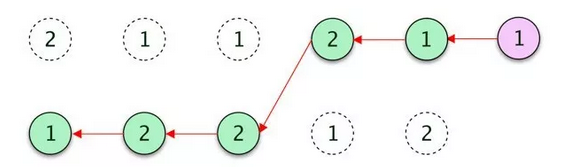

La ruta final más probable en este caso se da en el siguiente diagrama, que es similar a lo definido en fig 1.
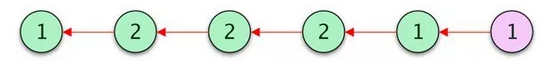

In [1]:
# Importacion de librerias conocidas
import pandas as pd
import numpy as np

In [2]:
# Se definen las funciones para cada algoritmo

#Algoritmo Fordward para busqueda del mejor modelo MOM o HMM
def forward(V, a, b, initial_distribution):
    alpha = np.zeros((V.shape[0], a.shape[0])) #Renglon, Columna
    alpha[0, :] = initial_distribution * b[:, V[0]]

    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            # Matrix Computation Steps
            #                  ((1x2) . (1x2))      *     (1)
            #                        (1)            *     (1)
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]

    return alpha


def backward(V, a, b):
    beta = np.zeros((V.shape[0], a.shape[0]))

    # configuración beta (T) = 1
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))

    # Bucle hacia atrás desde T-1 a
    # Debido a la indexación de Python, el bucle real será T-2 a 0
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j, :])

    return beta


def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)

    for n in range(n_iter):
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)

        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator

        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # Agregar elemento T'th adicional en gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)

        b = np.divide(b, denominator.reshape((-1, 1)))

    return (a, b)


def viterbi(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]

    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])

    prev = np.zeros((T - 1, M))

    for t in range(1, T):
        for j in range(M):
            # Igual que la probabilidad de avance (Fordward)
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])

            # Este es nuestro estado más probable dado el estado anterior en el tiempo t (1)
            prev[t - 1, j] = np.argmax(probability)

            # Esta es la probabilidad del estado más probable (2)
            omega[t, j] = np.max(probability)

    # Array de ruta
    S = np.zeros(T)

    #Encuentra el último estado oculto más probable
    last_state = np.argmax(omega[T - 1, :])

    S[0] = last_state

    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1

    # Voltear la matriz de ruta ya que estábamos retrocediendo
    S = np.flip(S, axis=0)

    # Convertir valores numéricos a estados ocultos reales
    result = []
    for s in S:
        if s == 0:
            result.append("A")
        else:
            result.append("B")

    return result


In [3]:
#Se carga los datos
data = pd.read_csv('data_python.csv')

In [4]:
print data

    Hidden  Visible
0        B        0
1        B        1
2        B        2
3        B        2
4        B        2
5        B        2
6        B        2
7        B        2
8        B        2
9        B        2
10       B        2
11       B        2
12       B        2
13       B        2
14       B        2
15       B        2
16       B        1
17       B        2
18       B        2
19       B        2
20       B        2
21       B        1
22       A        1
23       A        1
24       A        0
25       A        2
26       A        1
27       A        2
28       A        0
29       A        2
..     ...      ...
470      B        2
471      A        2
472      A        0
473      A        1
474      A        2
475      A        0
476      A        0
477      A        1
478      A        0
479      A        1
480      A        1
481      A        1
482      A        2
483      A        1
484      A        0
485      A        1
486      A        2
487      A        1


In [5]:
# De data se sustrae solo los valores de la columna "Visible" de cada uno de los 500 datos
V = data['Visible'].values
print "Logitud de V es:", len(V)
print V

Logitud de V es: 500
[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 0 2 1 2 0 2 0 1 2 1 2 0 2
 0 2 2 0 2 2 2 0 0 1 0 1 2 2 2 2 0 2 2 2 1 2 0 1 0 0 2 1 2 1 1 1 0 2 0 0 1
 1 2 0 1 2 0 1 0 2 1 0 0 2 0 1 0 2 1 2 1 1 2 1 2 2 2 1 2 1 2 1 1 1 2 2 1 2
 2 1 2 2 2 2 2 2 2 0 0 0 1 1 1 2 1 0 1 0 1 0 1 2 0 2 2 1 0 0 1 1 2 2 0 2 0
 0 0 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 0 2 2 2 2 2 2 2 2 0 2 1 2 1 1 1 2 2
 2 2 2 2 2 0 2 2 2 2 2 1 2 1 2 1 2 0 2 0 1 2 0 1 0 1 1 2 2 2 2 2 2 2 2 2 1
 0 0 1 2 1 0 2 2 1 2 2 2 1 0 1 2 2 2 1 0 1 0 2 2 1 2 2 2 1 2 2 2 2 0 2 0 1
 1 2 0 0 2 2 2 1 1 0 0 1 2 1 2 1 0 2 0 2 2 0 0 0 1 0 1 1 1 2 2 0 1 2 2 2 0
 1 1 2 2 0 1 2 2 2 2 2 2 0 1 2 2 0 2 0 2 2 2 1 2 2 2 1 1 1 1 2 0 0 0 2 2 1
 1 2 1 0 2 1 1 1 0 1 2 1 2 1 2 2 2 0 2 0 0 2 2 2 2 2 2 1 0 1 1 1 2 1 2 2 2
 2 2 1 1 2 2 2 2 2 2 0 1 2 0 1 2 1 2 0 2 1 0 2 2 0 2 2 0 2 2 2 2 0 2 2 2 1
 2 0 2 1 2 2 2 1 2 2 2 0 0 2 1 2 2 2 2 2 2 2 1 2 2 2 0 2 2 1 2 2 2 2 1 2 0
 2 1 2 2 0 1 0 1 2 1 0 2 2 2 1 0 1 0 2 1 2 2 2 0 2 1 2 2 0 1 2 0 0 1 0 1 1
 1 2

In [6]:
# Probabilidad de la transicion
a = np.ones((2, 2))
a = a / np.sum(a, axis=1)
print a

[[0.5 0.5]
 [0.5 0.5]]


In [7]:
# Probabilidad de emision
b = np.array(((1.0, 3.0, 5.0), (2.0, 4.0, 6.0)))
b = b / np.sum(b, axis=1).reshape((-1, 1))
print b

[[0.11111111 0.33333333 0.55555556]
 [0.16666667 0.33333333 0.5       ]]


In [8]:
# Igualdad de probabilidades para la distribución inicial.
initial_distribution = np.array((0.5, 0.5))

a, b = baum_welch(V, a, b, initial_distribution, n_iter=100)
print "Valores de a y b:", a,b
print(viterbi(V, a, b, initial_distribution))

Valores de a y b: [[0.53816345 0.46183655]
 [0.48664443 0.51335557]] [[0.16277513 0.26258073 0.57464414]
 [0.2514996  0.27780971 0.47069069]]
['B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A